# ISOMAP을 활용한 화학 분자의 시각화
#### 제작 : 허종국 (hjkso1406@korea.ac.kr)

뇌혈관장벽 투과성, 용해도, 전기음성도 등 화학 분자의 물성을 예측하는 것은 화학 정보학 분야에서 가장 중요한 태스크 중 하나입니다.
이러한 물성은 화학 분자가 가진 작용기나 구조적 특징(Scaffold)에 의해 주로 결정됩니다.
이번 튜토리얼은 PubChem이라는 1000만개의 unlabeled data에서 분자를 공통된 Scaffold에 따라 임의로 레이블링 한 뒤, ISOMAP을 통해 Scaffold에 해당하는 분자들이 어떻게 분포하고 있는지에 대해 알아보도록 하겠습니다.
* Caution : 해당 튜토리얼을 진행하기에 앞서 rdkit 패키지를 설치해주세요! 참고로 rdkit package는 python 3.8 이상부터는 에러가 나므로 3.7 환경에서 하는 것을 권장 드립니다.
* 본 튜토리얼에서 사용한 이미지는 고려대학교 강필성 교수님의 대학원 강의인 Business Analytics 강의 자료에서 첨부하였음을 알립니다.

In [1]:
#패키지 로딩
from utils import read_pubchem_smiles, generate_scaffolds
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from multiprocessing import Pool
from config import DESCRIPTORS
from rdkit.Chem import Descriptors
import warnings
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra
warnings.filterwarnings('ignore')


random.seed(777)
np.random.seed(777)


## ISOMAP
ISOMAP 은 아래 그림과 같이 현재 객체가 존재하는 좌표가 아닌 Manifold 상에서 MDS를 적용하는 방법론입니다.
ISOMAP은 k nearest neighbor 혹은 epsilon neighbor를 통해 객체 간의 인접도를 고려한 그래프를 구축하여 Manifold로 사용합니다.
이후 이웃하지 않은 개별 객체간의 Distance 는 Floyd 알고리즘 혹은 Dijkstra 알고리즘을 통해 계산하여 MDS를 계산합니다.
본 튜토리얼에서는 knn으로 그래프를 구축하고, Dijkstra 알고리즘을 통해 최단거리를 계산하는 ISOMAP을 통해 분자를 시각화해보도록 합니다.
ISOMAP의 단계는 다음과 같습니다.
- 1. 원본 좌표계로부터 거리 행렬 D를 구한다.
- 2. 원본 좌표계의 거리 행렬 D로부터 k nearest neighbor를 통해 객체간의 인접도를 고려한 그래프를 구축한다.
- 3. 개별 객체 간의 거리를 Dijkstra 알고리즘을 통해 구한다.
    - Input : $$ Coordinates (X)$$
    - Ouput : $$ Coordinates (X')$$
<img src='./images/fig2-1.png' width='800'></img>

* Caution : knn 으로 그래프를 구축할 경우 객체간의 거리가 비대칭일 수 있습니다. i객체의 이웃인 j객체가 i를 이웃으로 판단하지 않을 수 있기 때문입니다. 해당 경우를 고려하여 graph distance를 대칭화하는 후속 작업이 필요합니다.
* Caution : eps로 그래프를 구축할 경우 연결되지 않은 다수의 그래프가 생길 수 있습니다. 이러한 경우 그래프 내의 특정 개체를 임의로 연결시켜주는 작업이 필요합니다. 본 튜토리얼에서는 진행하지 않습니다.

In [37]:
def construct_knn_distance_matrix(X: np.array, k: int=5):
    pairwise_distances = cdist(X, X, 'euclidean')
    knn_indices = pairwise_distances.argsort()[:, :k+1]
    row_indices = np.repeat(np.array(range(0, X.shape[0]*X.shape[0], X.shape[0])), repeats=k+1)

    graph_distances = np.zeros((X.shape[0], X.shape[0]), dtype=float)
    
    flat_indices = knn_indices.reshape(-1) + row_indices
    flat_vals = np.take(pairwise_distances.reshape(-1), flat_indices, 0)
    np.put(graph_distances.reshape(-1), flat_indices, flat_vals)
    graph_distances = graph_distances.reshape(X.shape[0], -1)
    graph_distances = (graph_distances + graph_distances.T)/2
    graph_distances = np.where(graph_distances <= 0, 1e3, graph_distances)
    np.fill_diagonal(graph_distances, 0.0)
    assert (graph_distances == graph_distances.T).all()
    return graph_distances

def dijkstra_distances(distance_matrix):
    graph = csr_matrix(distance_matrix)
    dist_matrix = dijkstra(csgraph=graph)
    return distance_matrix

def multidimensional_scaling(distance_matrix: np.array):
    assert distance_matrix.shape[0] == distance_matrix.shape[1]
    
    n = distance_matrix.shape[0]
    
    A = -0.5 * np.power(distance_matrix, 2)
    H = np.identity(n) - np.ones((n, n), dtype=float)/n
    B = H @ A @ H
    
    p = np.linalg.matrix_rank(B)
    e_lambda, e_v= np.linalg.eig(B)
    
    X = e_v[:, :p] @ np.diag(np.sqrt(e_lambda[:p]))
    return X

def ISOMAP(X: np.array, k: int=5):
    knn_distance_matrix = construct_knn_distance_matrix(X, k)
    dijkstra_distance_matrix = dijkstra_distances(knn_distance_matrix)
    X_prime = multidimensional_scaling(dijkstra_distance_matrix)
    return X_prime

## Load SMILES from PubChem 10M Dataset
- 본 튜토리얼에서 사용하는 PubDhem Dataset은 약 10M개의 텍스트로 구성되어 있습니다.
- 각 텍스트는 화학 분자를 일련의 문자열로 표기하는 SMILES 표기 규칙으로 작성되어 있습니다.
- 각 분자에 따른 시각화와 그에 따른 SMILES 표기는 아래 예시와 같습니다.

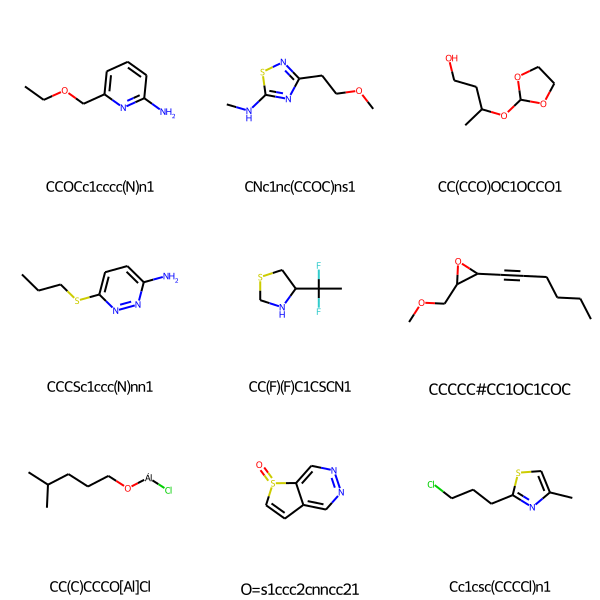

In [38]:
smiles = read_pubchem_smiles('./data/pubchem-10m-clean.txt')

sample_smiles = random.sample(sorted(smiles, key=lambda x: len(x))[10000:15000],9)
sample_mols = [Chem.MolFromSmiles(m) for m in sample_smiles]
Draw.MolsToGridImage(sample_mols, legends=sample_smiles)

## Generate Scaffolds with PubChem Data
- Scaffold 는 분자를 이루는 큰 뼈대를 뜻합니다. Scaffold 혹은 작용기 등 구조가 비슷한 분자는 비슷한 물성을 가지고 있을 확률이 높습니다.
- 따라서 각 분자별로 Scaffold를 추출하고 공통된 Scaffold에 속한 분자들을 같은 Class로 정의하겠습니다.
- PubChem의 데이터 개수가 너무 많은 관계로 약 2만개의 분자만을 가지고 실습을 진행하겠습니다.

In [39]:
total_scaffold_sets = generate_scaffolds(smiles[:20000])

Total Data Size 20000, about to generate scaffolds
Generating scaffold 0/20000
Generating scaffold 1000/20000
Generating scaffold 2000/20000
Generating scaffold 3000/20000
Generating scaffold 4000/20000
Generating scaffold 5000/20000
Generating scaffold 6000/20000
Generating scaffold 7000/20000
Generating scaffold 8000/20000
Generating scaffold 9000/20000
Generating scaffold 10000/20000
Generating scaffold 11000/20000
Generating scaffold 12000/20000
Generating scaffold 13000/20000
Generating scaffold 14000/20000
Generating scaffold 15000/20000
Generating scaffold 16000/20000
Generating scaffold 17000/20000
Generating scaffold 18000/20000
Generating scaffold 19000/20000


## Draw Molecules with Same Scaffolds

아래 그림은 Scaffold 2, 7, 77, 82, 100번에 대해 속해있는 분자들의 예시입니다.
각 행의 첫번째 그림은 Scaffold, 두번째에서 네번째 그림은 해당 Scaffold를 가지고 있는 분자들입니다.

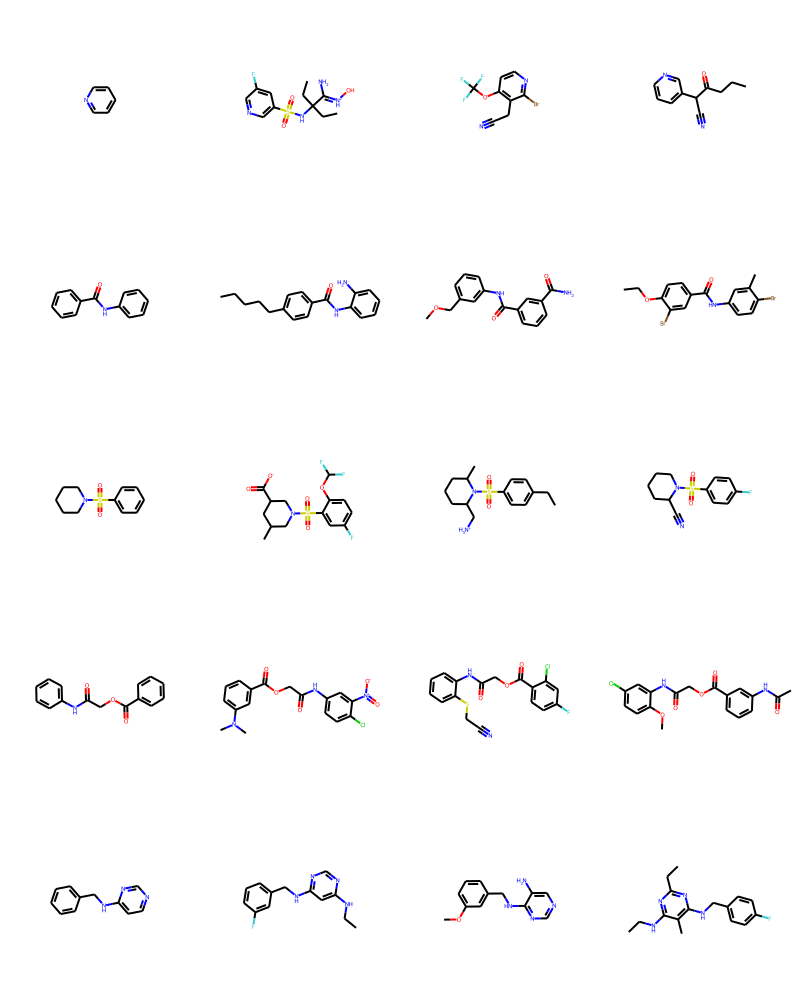

In [40]:
scaffold_sets = [(scaffold, list(map(lambda i: smiles[i], indices))) for scaffold, indices in list(map(lambda i: total_scaffold_sets[i], [2, 7, 77, 82, 100]))]


scaffold_samples = list(itertools.chain(*[(k, *v[:3]) for k, v in scaffold_sets]))
scaffold_samples = [Chem.MolFromSmiles(m) for m in scaffold_samples]
Draw.MolsToGridImage(scaffold_samples, molsPerRow=4)

In [41]:
indices = list(itertools.chain(*[[idx] * len(molecules) for idx, (scaffold, molecules) in enumerate(scaffold_sets)]))
molecules = list(itertools.chain(*[molecules for scaffold, molecules in scaffold_sets]))

## Molecular Feature Descriptor
- 지난 MDS 튜토리얼에서는 원본 좌표계가 필요없이 분자간 유사도만을 가지고 Distance Matrix를 구축했습니다.
- ISOMAP은 Manifold를 구하기 위해 원본 좌표계가 필요하기 때문에 본 튜토리얼에서는 분자의 특징을 수동으로 추출하였습니다.
- Molecular Descriptor란 분자 내의 원자 개수 등 여러가지 특징을 의미합니다.
- 본 튜토리얼에서는 rdkit에서 제공하는 122개의 Molecular Descriptor를 통해 분자의 특징을 추출하고, Standard Scaler를 통해 정규화합니다.

In [42]:
df = pd.DataFrame()
df['molecules'] = molecules
df['scaffold_index'] = pd.Series(indices)
features = []

for feature in DESCRIPTORS:
    df[feature] = df['molecules'].apply(lambda x: getattr(Descriptors, feature)(Chem.MolFromSmiles(x)))
    features.append(feature)
    
df[features] = StandardScaler().fit_transform(df[features].values)
df.head()

,molecules,scaffold_index,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BCUT2D_MWHI,BCUT2D_MWLOW,...,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9
0,CCC(CC)(NS(=O)(=O)c1cncc(F)c1)C(N)=[NH+]O,0,2.310532,-1.494305,-0.098909,-1.891257,0.392935,-1.757795,-0.199476,-1.619475,...,1.519918,-0.717449,-1.185376,0.583922,0.940481,-0.541712,-1.069538,0.412266,0.051881,-2.287312
1,N#CCc1c(OC(F)(F)F)ccnc1Br,0,1.541836,0.281143,1.028795,0.558704,1.040478,-0.521573,1.518341,0.341966,...,1.509882,0.016303,-1.129296,0.255154,-0.705273,-0.208907,-0.592276,-1.717531,-1.074387,-0.142442
2,CCCC(=O)C(C#N)c1cccnc1,0,0.195175,0.955759,-0.336529,0.883481,-0.684656,-0.108008,-0.779270,-1.461653,...,-0.798076,-0.717449,0.140236,0.319968,-0.476258,-0.391979,0.075446,1.047820,-0.439463,-0.142442
3,CC(C)C(C)CNc1ncc(Br)cc1Cl,0,-0.773865,-0.281413,0.361724,0.616039,1.040677,1.375741,1.518341,-1.219982,...,-0.745962,1.614333,-1.073730,-0.401264,-0.735753,1.481379,-0.826090,0.149072,1.407776,-0.142442
4,Cc1cncc(S(=O)(=O)Cl)c1,0,-0.735125,2.238899,-0.661737,1.618456,0.522149,1.826892,-0.073404,1.383842,...,0.444900,-0.717449,-1.126982,-0.969028,-0.445446,0.077076,-0.918784,0.495904,-0.498001,0.628877


## Calculate Distance via Molecular Features gained by Descriptors
- 정규화된 분자 특징을 원본 좌표계로 사용하여 ISOMAP으로 차원축소를 진행합니다.

In [43]:
coordinate_matrix = ISOMAP(df[features].values, k=30)
coordinates = coordinate_matrix[:,:2]

- MDS와 마찬가지로 2번(빨간색)과 4번(파란색) Scaffold에 속하는 분자들은 매우 유사하다고 판단하였습니다.
- 2번과 4번은 MDS에서 설명하였다시피 두 개의 벤젠 사이에 카보닐기가 존재하는 분자들이기 때문으로 추측합니다.
- 1번은 벤젠과 유사하게 생겼지만 탄소하나가 질소로 치환된 피리딘 계열입니다. 벤젠과 피리딘은 아래 그림과 같습니다.

    <img src='./images/fig2-2.png' width='800'></img>
    
- 따라서 피리딘을 포함하는 보라색 분자들은 빨간색/파란색과 매우 먼 거리를 가지게 됩니다.
- 벤젠 구조를 하나만 공통으로 가지고 있는 노란색/초록색은 유사한 분자(Manifold 상에서 분리가 잘 이루어지지 않음)이라고 판단한 것을 알 수 있습니다.
- 하지만 피리딘 계열에 비해 노란색/초록색 분자들은 벤젠이라는 고리가 들어가있다는 측면에서 빨간색/파란색 분자와 가깝게 매핑됩니다.

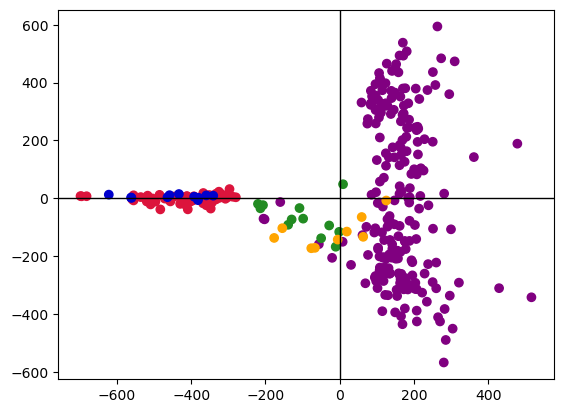

In [44]:
scaffold_colors = ['purple', 'crimson', 'forestgreen', 'mediumblue', 'orange']

colors = [scaffold_colors[idx] for idx in indices]
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=colors)
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)
plt.show()